<a href="https://colab.research.google.com/github/legchikov/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Down the rabbit hole with Tensorflow

![img](https://lh3.googleusercontent.com/I1Dpp7I9RZIGl0rVMlPfnhfl-bkl_2uDHZwVC87BWmqtPaAs1irMWOdJxTmTEQJB-VGfLryCyHxqvyNchVIVLL-vqGrF3Q=s688)

In this seminar, we're going to play with [Tensorflow](https://www.tensorflow.org/) and see how it helps you build deep learning models.

If you're running this notebook outside the course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf

# session is main tensorflow object. You ask session to compute stuff for you.
sess = tf.InteractiveSession()

# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [0]:
def sum_squares(N):
    return sum(i*i for i in range(N))

In [0]:
# https://codereview.stackexchange.com/questions/58460/sum-of-squares-square-of-sum-difference
# https://trans4mind.com/personal_development/mathematics/series/sumNaturalSquares.htm
def sum_squares_O1(n):
    return n*(n+1)*(2*n+1)/6

In [0]:
%%time
sum_squares(10**8)

CPU times: user 13.8 s, sys: 3.76 ms, total: 13.8 s
Wall time: 13.8 s


333333328333333350000000

In [0]:
%%time
sum_squares_O1(10**8)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 15.5 µs


3.333333383333333e+23

__Same with tensorflow__

In [0]:
# "i will insert N here later"
N = tf.placeholder('int64', name="input_to_your_function")

# a recipe on how to produce {sum of squares of arange of N} given N
result = tf.reduce_sum((tf.range(N)**2))

In [0]:
%%time

# dear session, compute the result please. Here's your N.
print(sess.run(result, {N: 10**8}))

# hint: run it several times to let tensorflow "warm up"

662921401752298880
CPU times: user 581 ms, sys: 653 ms, total: 1.23 s
Wall time: 1.05 s


# How it works: computation graphs


1. create placeholders for future inputs;
2. define symbolic graph: a recipe for mathematical transformation of those placeholders;
3. compute outputs of your graph with particular values for each placeholder
  * ```sess.run(outputs, {placeholder1:value1, placeholder2:value2})```
  * OR output.eval({placeholder:value}) 

Still confused? We gonna fix that.

__Placeholders and constants__

In [0]:
# placeholder that can be arbitrary float32 scalar, vertor, matrix, etc.
arbitrary_input = tf.placeholder('float32')

# input vector of arbitrary length
input_vector = tf.placeholder('float32',shape=(None,))

# input vector that _must_ have 10 elements and integer type
fixed_vector = tf.placeholder('int32',shape=(10,))

# you can generally use None whenever you don't need a specific shape
input1 = tf.placeholder('float64',shape=(None, 100, None))
input2 = tf.placeholder('int32',shape=(None, None, 3, 224, 224))

You can create new __tensors__ with arbitrary operations on placeholders, constants and other tensors.

* tf.reduce_sum(tf.arange(N)\**2) are 3 sequential transformations of placeholder N
* there's a tensorflow symbolic version for every numpy function
  * `a + b, a / b, a ** b, ...` behave just like in numpy
  * np.zeros -> tf.zeros
  * np.sin -> tf.sin
  * np.mean -> tf.reduce_mean
  * np.arange -> tf.range
  
There are tons of other stuff in tensorflow, see the [docs](https://www.tensorflow.org/api_docs/python) or learn as you go with __shift+tab__.

In [0]:
# elementwise multiplication
double_the_vector = input_vector * 2

# elementwise cosine
elementwise_cosine = tf.cos(input_vector)

# elementwise difference between squared vector and it's means - with some random salt
vector_squares = input_vector ** 2 - tf.reduce_mean(input_vector) + tf.random_normal(tf.shape(input_vector))


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-11-12 15:35:39--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.174.228.92, 54.164.206.44, 52.44.92.122, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.174.228.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.87MB/s    in 0.5s    

2018-11-12 15:35:40 (9.87 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = '/tmp/log'

In [0]:
# summary_writer = tf.train.FileWriter(LOG_DIR, sess.graph_def)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://989d0ed5.ngrok.io


In [0]:
!rm /tmp/log/*

In [0]:
!ls /tmp/log/

ls: cannot access '/tmp/log/': No such file or directory


## Practice 1: polar pretzels
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


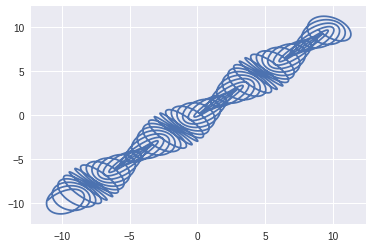

In [0]:
t = tf.placeholder('float32')


# compute x(t) and y(t) as defined above.
x = t - 1.5* tf.cos(15*t)
y = t - 1.5* tf.sin(16*t)


x_points, y_points = sess.run([x, y], {t: np.linspace(-10, 10, num=10000)})
plt.plot(x_points, y_points);

writer = tf.summary.FileWriter(LOG_DIR, graph=sess.graph)

### Visualizing graphs with Tensorboard

It's often useful to visualize the computation graph when debugging or optimizing. 
Interactive visualization is where tensorflow really shines as compared to other frameworks. 

There's a special instrument for that, called Tensorboard. You can launch it from console:

__```tensorboard --logdir=/tmp/tboard --port=7007```__

If you're pathologically afraid of consoles, try this:

__```import os; os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")```__

_(but don't tell anyone we taught you that)_

One basic functionality of tensorboard is drawing graphs. One you've run the cell above, go to `localhost:7007` in your browser and switch to _graphs_ tab in the topbar. 

Here's what you should see:

<img src="https://www.tensorflow.org/images/graph_vis_animation.gif" width=480>

Tensorboard also allows you to draw graphs (e.g. learning curves), record images & audio ~~and play flash games~~. This is useful when monitoring learning progress and catching some training issues.

One researcher said:
```
If you spent last four hours of your worktime watching as your algorithm prints numbers and draws figures, you're probably doing deep learning wrong.
```

You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz)

# Practice 2: mean squared error


In [0]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

v1 = tf.placeholder('float32',shape=(None,))
v2 = tf.placeholder('float32',shape=(None,))

mse = tf.reduce_mean(tf.math.square(v1 - v2))

compute_mse = lambda vector1, vector2: sess.run(mse, {v1: vector1, v2: vector2})

In [0]:
v1 = tf.placeholder('float32',shape=(None,))
v2 = tf.placeholder('float32',shape=(None,))

# q = tf.math.square(v1 - v2)
q = tf.math.squared_difference(v1, v2)

vector1 = np.array([1, 2])
vector2 = np.array([3, 4])
print(sess.run(q, {v1: vector1, v2: vector2}))

[4. 4.]


In [0]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10 ** 3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el,el_2))
                print("should be: %f, but your function returned %f" % (true_mse,my_mse))
                raise ValueError("Что-то не так")

print("All tests passed")    

All tests passed


# Tensorflow variables

The inputs and transformations have no value outside function call. That's a bit unnatural if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [0]:
# creating shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5))

# initialize all variables with initial values
sess.run(tf.global_variables_initializer())

In [5]:
# evaluating shared variable (outside symbolicd graph)
print("initial value", sess.run(shared_vector_1))

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [1. 1. 1. 1. 1.]


In [6]:
# setting new value manually
sess.run(shared_vector_1.assign(np.arange(5)))

#getting that new value
print("new value", sess.run(shared_vector_1))


new value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* Gradients are computed as a product of elementary derivatives via chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [0]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar ** 2

#a derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar])[0]

In [14]:
x = np.linspace(-3,3)
x

array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
       -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
       -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
       -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
       -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
        0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
        0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
        1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
        1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
        2.51020408,  2.63265306,  2.75510204,  2.87755102,  3.        ])

In [11]:
x_squared, x_squared_der = sess.run([scalar_squared, derivative], {my_scalar:x})
x_squared, x_squared_der

(array([9.0000000e+00, 8.2803001e+00, 7.5905881e+00, 6.9308619e+00,
        6.3011246e+00, 5.7013745e+00, 5.1316123e+00, 4.5918365e+00,
        4.0820489e+00, 3.6022491e+00, 3.1524365e+00, 2.7326117e+00,
        2.3427739e+00, 1.9829239e+00, 1.6530612e+00, 1.3531862e+00,
        1.0832986e+00, 8.4339857e-01, 6.3348603e-01, 4.5356098e-01,
        3.0362347e-01, 1.8367347e-01, 9.3710959e-02, 3.3735946e-02,
        3.7484383e-03, 3.7484383e-03, 3.3735946e-02, 9.3710959e-02,
        1.8367347e-01, 3.0362347e-01, 4.5356098e-01, 6.3348603e-01,
        8.4339857e-01, 1.0832986e+00, 1.3531862e+00, 1.6530612e+00,
        1.9829239e+00, 2.3427739e+00, 2.7326117e+00, 3.1524365e+00,
        3.6022491e+00, 4.0820489e+00, 4.5918365e+00, 5.1316123e+00,
        5.7013745e+00, 6.3011246e+00, 6.9308619e+00, 7.5905881e+00,
        8.2803001e+00, 9.0000000e+00], dtype=float32),
 array([-6.        , -5.755102  , -5.5102043 , -5.265306  , -5.020408  ,
        -4.7755103 , -4.5306125 , -4.285714  , -4.040816

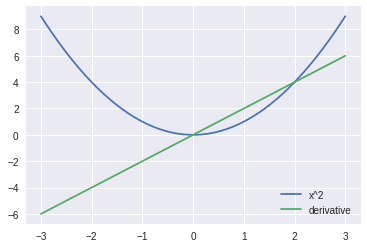

In [8]:
plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend();

## Why autograd is cool

In [0]:
my_vector = tf.placeholder('float32',[None])

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2)*tf.exp((my_scalar-4)**2)/(1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/(1+tf.exp(-(my_scalar-4)**2)))**2
 
der_by_scalar = tf.gradients(weird_psychotic_function, [my_scalar])[0]
der_by_vector = tf.gradients(weird_psychotic_function, [my_vector])[0]

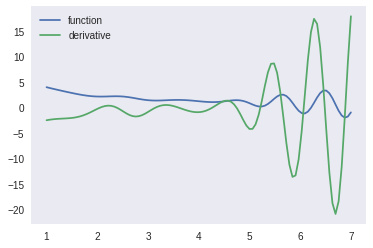

In [17]:
#Plotting your derivative
scalar_space = np.linspace(1, 7, 100)

y = [sess.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [sess.run(der_by_scalar, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [0]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss,var_list=y_guess)

# same, but more detailed:
# updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
# optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)

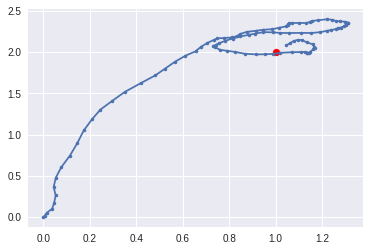

In [19]:
from IPython.display import clear_output

sess.run(tf.global_variables_initializer())

guesses = [sess.run(y_guess)]

for _ in range(100):
    sess.run(optimizer)
    guesses.append(sess.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses), marker='.')
    plt.scatter(*sess.run(y_true), c='red')
    plt.show()

# Logistic regression example
Implement the regular logistic regression training algorithm
 
We shall train on a two-class MNIST dataset. 

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


The natural choice of loss function is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$

Mind the minus :)


In [0]:
from sklearn.datasets import load_digits
X, y = load_digits(2, return_X_y=True)

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

In [0]:
print('X:\n', X[:3,:10])
print('y:\n', y[:10])
plt.imshow(X[0].reshape([8,8]))

In [0]:
# inputs and shareds
weights = <student.create_variable()>
input_X = <student.create_placeholder_matrix()>
input_y = <student.code_placeholder_vector()>

In [0]:
predicted_y_proba = <predicted probabilities for input_X using weights>

loss = <logistic loss (scalar, mean over sample) between predicted_y_proba and input_y>

train_step = <operator that minimizes loss>

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    
    loss_i, _ = sess.run([loss, train_step], ###<YOUR CODE: feed values to placeholders>)
    
    print("loss at iter %i: %.4f" % (i, loss_i))
    
    print("train auc:", roc_auc_score(y_train, sess.run(predicted_y_proba, {input_X: X_train})))
    print("test auc:", roc_auc_score(y_test, sess.run(predicted_y_proba, {input_X: X_test})))

    
print ("resulting weights:")
plt.imshow(sess.run(weights).reshape(8, -1))
plt.colorbar();

# Practice 3: my first tensorflow network
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure tensorflow.

This time you will same digit recognition problem, but at a larger scale
* images are now 28x28
* 10 different digits
* 50k samples

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) NN should already have ive you an edge over logistic regression.

__[bonus score]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! The milestones would be 95%/97.5%/98.5% accuraсy on test set.

__SPOILER!__
At the end of the notebook you will find a few tips and frequently made mistakes. If you feel enough might to shoot yourself in the foot without external assistance, we encourage you to do so, but if you encounter any unsurpassable issues, please do look there before mailing us.

In [0]:
from mnist import load_dataset

# [down]loading the original MNIST dataset.
# Please note that you should only train your NN on _train sample,
#  _val can be used to evaluate out-of-sample error, compare models or perform early-stopping
#  _test should be hidden under a rock untill final evaluation... But we both know it is near impossible to catch you evaluating on it.
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print (X_train.shape,y_train.shape)

In [0]:
plt.imshow(X_train[0,0])

In [0]:
<this cell looks as if it wants you to create variables here>

In [0]:
<you could just as well create a computation graph here - loss, optimizers, all that stuff>

In [0]:
<this may or may not be a good place to run optimizer in a loop>

In [0]:
<this may be a perfect cell to write a training & evaluation loop in>

In [0]:
<predict & evaluate on test here, right? No cheating pls.>

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from previous assignment to classify some number against others (e.g. zero vs nonzero)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as T.nnet.softmax (stable)
  - probably better to use STOCHASTIC gradient descent (minibatch)
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - Do not initialize layers with zeros (due to symmetry effects). A gaussian noize with small sigma will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.